# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [385]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [386]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [387]:
# descriptive statistics:
# -----------------------
#
# show dimensions of datasets
print('Dimensions of "df": {}'.format(df.shape))
print('Dimensions of "df_content": {}'.format(df_content.shape))

Dimensions of "df": (45993, 3)
Dimensions of "df_content": (1056, 5)


In [388]:
# count number of interactions for each user
df['email'].value_counts()

2b6c0f514c2f2b04ad3c4583407dccd0810469ee    364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66    170
a37adec71b667b297ed2440a9ff7dad427c7ac85    169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93    160
f8c978bcf2ae2fb8885814a9b85ffef2f54c3c76    158
284d0c17905de71e209b376e3309c0b08134f7e2    148
d9032ff68d0fd45dfd18c0c5f7324619bb55362c    147
18e7255ee311d4bd78f5993a9f09538e459e3fcc    147
c60bb0a50c324dad0bffd8809d121246baef372b    145
276d9d8ca0bf52c780b5a3fc554fa69e74f934a3    145
56832a697cb6dbce14700fca18cffcced367057f    144
b2d2c70ed5de62cf8a1d4ded7dd141cfbbdd0388    142
ceef2a24a2a82031246814b73e029edba51e8ea9    140
8dc8d7ec2356b1b106eb3d723f3c234e03ab3f1e    137
e38f123afecb40272ba4c47cb25c96a9533006fa    136
53db7ac77dbb80d6f5c32ed5d19c1a8720078814    132
6c14453c049b1ef4737b08d56c480419794f91c2    131
fd824fc62b4753107e3db7704cd9e8a4a1c961f1    116
c45f9495a76bf95d2633444817f1be8205ad542d    114
12bb8a9740400ced27ae5a7d4c990ac3b7e3c77d

We can see that there are two users that are responsible for 364 respectively 363 interactions and lots of users with only one interaction.
Thus, we expect a right-skewed distribution according to this description.

In [389]:
# show statistical parameters of users
df['email'].value_counts().describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: email, dtype: float64

The result of the describe()-function supports the thesis stated above since the mean is only around 9 interactions and the median of the distribution is only 3.

In [390]:
# count interactions for each article
df['article_id'].value_counts()

1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
1314.0    614
1293.0    572
1170.0    565
1162.0    512
1304.0    483
1436.0    481
1271.0    473
1398.0    465
43.0      460
1351.0    457
1393.0    455
1185.0    442
1160.0    433
1354.0    426
1368.0    418
1305.0    413
1338.0    382
1336.0    379
1165.0    372
1172.0    363
151.0     352
1276.0    347
1432.0    340
1430.0    336
1052.0    330
         ... 
1208.0      2
778.0       2
1283.0      2
1135.0      2
1210.0      2
430.0       2
416.0       2
1251.0      2
1227.0      2
1230.0      2
1086.0      2
1156.0      2
1266.0      1
653.0       1
1233.0      1
1127.0      1
1092.0      1
1119.0      1
675.0       1
724.0       1
1237.0      1
1202.0      1
1344.0      1
662.0       1
1200.0      1
974.0       1
417.0       1
1113.0      1
984.0       1
1072.0      1
Name: article_id, Length: 714, dtype: int64

In [391]:
# show statistical parameters for articles
df['article_id'].value_counts().describe()

count    714.000000
mean      64.415966
std      109.175923
min        1.000000
25%        8.000000
50%       25.000000
75%       69.000000
max      937.000000
Name: article_id, dtype: float64

The distribution of article IDs is qualitalively quite similar to the user distribution. With a maximum count of interaction of 937, we have a mean of around 64 and a median of 25 interactions per article.

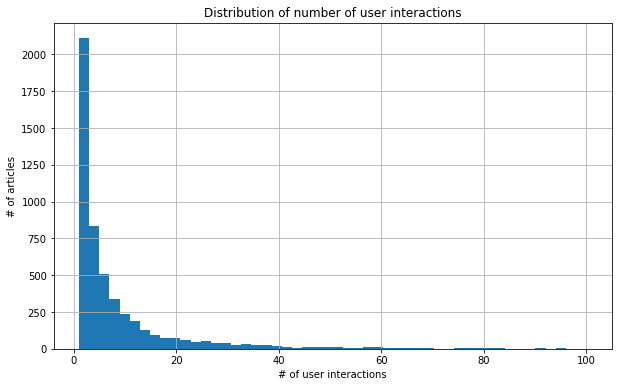

In [392]:
# visualizations
# --------------
# plot histogram of user interactions per article

user_article_interactions = df.groupby('email').count()['article_id']
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(user_article_interactions, bins = 50, range=(1,100))
ax.set_xlabel('# of user interactions')
ax.set_ylabel('# of articles')
ax.grid()
ax.set_title('Distribution of number of user interactions');

The visualization of user interaction distribution is as we expected. The distribution is right-skewed. Most of the users only interact a few times on articles. Thus, the majority of the distribution as well as the median is on the left side of the plot.

In [393]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [394]:
# Find and explore duplicate articles
df_content[df_content['article_id'].duplicated()]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


There are five duplicated articles in the dataset.

In [395]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset='article_id', keep='first',inplace=True)

In [396]:
# check for duplicates
df_content[df_content['article_id'].duplicated()].sum()

doc_body           0.0
doc_description    0.0
doc_full_name      0.0
doc_status         0.0
article_id         0.0
dtype: float64

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [397]:
# a. The number of unique articles that have an interaction with a user
df["article_id"].unique().shape[0]

714

In [398]:
# b. The number of unique articles in the dataset (whether they have any interactions or not)
df_content["article_id"].shape[0]

1051

In [399]:
# c. The number of unique users in the dataset. (excluding null values)
df["email"].dropna().unique().shape[0]

5148

In [400]:
# d. The number of user-article interactions in the dataset.
df.shape[0]

45993

In [401]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [402]:
most_viewed_articles = df["article_id"].value_counts().sort_values(ascending=False)
print("Most viewed article:")
print("ID:\t {}".format(most_viewed_articles.index[0]))
print("title:\t {}".format(df[df["article_id"]==most_viewed_articles.index[0]]["title"].values[0]))
print("views:\t {}".format(most_viewed_articles.values[0]))

Most viewed article:
ID:	 1429.0
title:	 use deep learning for image classification
views:	 937


In [403]:
most_viewed_article_id = "1429.0" # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [404]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [405]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [406]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = list(set(df[df['article_id'].isin(get_top_article_ids(n,df))]['title']))
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = [str(x) for x in df.article_id.value_counts().head(n).index]
 
    return top_articles # Return the top article ids

In [407]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['finding optimal locations of new store using decision optimization', 'analyze energy consumption in buildings', 'use deep learning for image classification', 'healthcare python streaming application demo', 'apache spark lab, part 1: basic concepts', 'insights from new york car accident reports', 'predicting churn with the spss random tree algorithm', 'gosales transactions for logistic regression model', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [408]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [409]:
# tests before implement the function
user_item = df.groupby(['user_id', 'article_id'])['title'].count().notnull().unstack()
user_item = user_item.notnull().astype(np.int)
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [410]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # group the dataframe by users and articles - count each title - convert into boolean - unstack grouped dataframe
    user_item = df.groupby(['user_id', 'article_id'])['title'].count().notnull().unstack()
    # convert True / False into 1 / 0
    user_item = user_item.notnull().astype(np.int)
        
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [411]:
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [412]:
user_item.to_pickle('user_item_matrix.p')

In [413]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [414]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    similarity = user_item.dot(user_item.loc[user_id])
    
    # sort by similarity (from top to bottom)
    similarity = similarity.sort_values(ascending = False)
    
    # create list of just the ids
    most_similar_users = list(similarity.index)
    
    # remove the own user's id
    most_similar_users.remove(user_id)
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [415]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [416]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # find the article names to the corresponding article ids and store in list
    article_names = list(set(df[df['article_id'].isin(article_ids)]['title']))    
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # find the article ids for the given user id in the user-article matrix
    article_ids = user_item.loc[user_id]
    
    # get the index (article_id) which is equal to one to filter the 0
    article_ids = list(article_ids[article_ids == 1].index.astype(str))
    
    # get corresponding article names 
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # find most similar users to the given user id
    user_ids = find_similar_users(user_id)
    
    # filter for user ids that are similar and store article ids
    recs = df[df['user_id'].isin(user_ids)]['article_id']
    
    # convert into list and store only m recommendations
    recs = list(set(recs))
    
    return recs[:m] # return your recommendations for this user_id    

In [417]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['3992    using apache spark to predict attack vectors a...\r\nName: title, dtype: object',
 'data science bowl 2017',
 'analyze ny restaurant data using spark in dsx',
 'higher-order logistic regression for large datasets',
 'the greatest public datasets for ai – startup grind',
 'detect malfunctioning iot sensors with streaming analytics',
 'this week in data science (april 18, 2017)',
 'apache spark™ 2.0: extend structured streaming for spark ml',
 'timeseries data analysis of iot events by using jupyter notebook',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium']

In [418]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [419]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    
    #calculate similarity of users with regard to user_id by using dot product
    similarity = user_item.dot(user_item.loc[user_id])
    
    # sort similarity in descending order
    similarity = similarity.sort_values(ascending=False)
    
    # drop user_id
    similarity = similarity.drop(user_id)
    
    # convert similarity into dataframe
    similarity = similarity.to_frame(name='similarity').reset_index()

    #count number of user interactions
    num_interactions = df.user_id.value_counts()
    
    # convert num_interactions to dataframe
    num_interactions = num_interactions.to_frame('num_interactions')
    
    # merge the created dataframes
    neighbors_df = similarity.merge(num_interactions, left_on='user_id', right_index=True)
    
    # rename user_id column to neighbor_id
    neighbors_df = neighbors_df.rename(columns={'user_id':'neighbor_id'})

    # sort dataframe by similarity in descending order
    neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False, inplace=True)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # find users with highest similarity to user_id
    neighbors_df = get_top_sorted_users(user_id)
    
    # get user_id of m most similar neighbors
    most_similar_neighbors = list(neighbors_df[:m]['neighbor_id'])

    # get article_ids interacted by the m most similar neighbors
    recs = []
    for user in most_similar_neighbors:
        article_ids = user_item.loc[user]
        recs.extend([art_id for art_id in article_ids[article_ids == 1].index.astype(str)])

    # remove duplicates and get the top m users
    recs = list(set(recs[:m]))

    # convert article_ids to article_names and remove duplicates
    rec_names = list(set(df[df['article_id'].isin(recs)]['title']))
    
    return recs, rec_names

In [420]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['164.0', '205.0', '336.0', '232.0', '142.0', '362.0', '12.0', '125.0', '109.0', '302.0']

The top 10 recommendations for user 20 are the following article names:
['dsx: hybrid mode', 'accelerate your workflow with dsx', 'neural networks for beginners: popular types and applications', 'learn tensorflow and deep learning together and now!', 'self-service data preparation with ibm data refinery', 'timeseries data analysis of iot events by using jupyter notebook', 'challenges in deep learning', "a beginner's guide to variational methods", 'tensorflow quick tips', 'statistics for hackers']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [421]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).iloc[0].neighbor_id # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).iloc[9].neighbor_id # Find the 10th most similar user to user 131

print('The user that is most similar to user 1 is user {}.'.format(user1_most_sim))
print('The 10th most similar user to user 131 is user {}.'.format(user131_10th_sim))

The user that is most similar to user 1 is user 3933.
The 10th most similar user to user 131 is user 242.


In [422]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Response:**

We cannot make recommendations for new users by using the functions above since they are based on user knowledge. For new users, we do not have any knowledge about his or her preferences, because he or she has not interacted with any of the articles. Thus, there is no similarity to calculate between the new user and older ones. We can only use knowledge based approaches in cases where the user has interacted with a certain amount of articles, because with a data basis of one or two user interactions for a user we might not conclude reasonable recommendations.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [423]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)



In [424]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [425]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [426]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [427]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [428]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [429]:
# Perform SVD on the User-Item Matrix Here

u, s, vh = np.linalg.svd(user_item_matrix, full_matrices=False) # use the built in to get the three matrices

In [430]:
print('Shape of u: {}'.format(u.shape))
print('Shape of s: {}'.format(s.shape))
print('Shape of vh: {}'.format(vt.shape))

Shape of u: (5149, 714)
Shape of s: (714,)
Shape of vh: (714, 714)


**Response:**

The Singular Value Decomposition only works in cases, where no missing values are present. In our user-item matrix, this condition is satisfied and we can apply this technique to factorize the 2D-matrix and, further, to make recommendations. In the video lessons, we had missing values and had to choose funkSVD for matrix factorization. 

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

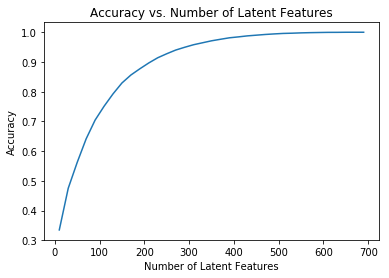

In [431]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [432]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # perform the create_user_item_matrix() function on the train and test dataset to get a corresponding user-item-matrix
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)

    # save ids of test users and test articles as lists
    test_idx = list(set(user_item_test.index))
    test_arts = list(set(user_item_test.columns))
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [433]:
print('Shape of user_item_train: {}'.format(user_item_train.shape))
print('Shape of user_item_test: {}'.format(user_item_test.shape))

Shape of user_item_train: (4487, 714)
Shape of user_item_test: (682, 574)


In [434]:
print('How many users can we make predictions for in the test set?: {}'.format(len(set(user_item_test.index) & set(user_item_train.index))))
print('How many users in the test set are we not able to make predictions for because of the cold start problem?: {}'.format(len(set(user_item_test.index) - set(user_item_train.index))))
print('How many articles can we make predictions for in the test set?: {}'.format(len(set(user_item_test.columns) & set(user_item_train.columns))))
print('How many articles in the test set are we not able to make predictions for because of the cold start problem?: {}'.format(len(set(user_item_test.columns) - set(user_item_train.columns))))

How many users can we make predictions for in the test set?: 20
How many users in the test set are we not able to make predictions for because of the cold start problem?: 662
How many articles can we make predictions for in the test set?: 574
How many articles in the test set are we not able to make predictions for because of the cold start problem?: 0


In [435]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict_1 = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
    }

t.sol_4_test(sol_4_dict_1)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [436]:
# fit SVD on the user_item_train matrix
u_train, s_train, vh_train = np.linalg.svd(user_item_train, full_matrices=False)
print('Shape of u_train: {}'.format(u_train.shape))
print('Shape of s_train: {}'.format(s_train.shape))
print('Shape of vh_train: {}'.format(vh_train.shape))

Shape of u_train: (4487, 714)
Shape of s_train: (714,)
Shape of vh_train: (714, 714)


In [437]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

# get the ids of commom users and article between the training and testing dataset
train_test_common_idx = user_item_train.index.isin(test_idx)
train_test_common_col = user_item_train.columns.isin(test_arts)

In [438]:
# show common users (20 as shown in the cells above) as an example
user_item_train[train_test_common_idx]

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
2917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3024,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3093,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3193,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3527,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3532,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3684,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3740,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
3777,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [439]:
# get the subsets of the training data for the u_test and vh_test arrays
u_test = u_train[train_test_common_idx, :]
vh_test= vh_train[:, train_test_common_col]

print('Shape of u_test: {}'.format(u_test.shape))
print('Shape of vh_test: {}'.format(vh_test.shape))

Shape of u_test: (20, 714)
Shape of vh_test: (714, 574)


In [440]:
# get the subset of the user-item-matrix by filtering the common user and article ids of training and testing dataset
user_item_test = user_item_test.loc[set(user_item_train.index) & set(user_item_test.index), set(user_item_train.columns) & set(user_item_test.columns)]

In [441]:
user_item_test

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1432.0,1433.0,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1443.0
user_id,,,,,,,,,,,,,,,,,,,,,
3968,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3777,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3684,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4293,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4487,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4231,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3527,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [442]:
# init features and errors variables
num_latent_features = np.arange(10,714,20)
sum_errors_train = []
sum_errors_test = []

# loop over number of latent features
for i in num_latent_features:
    # filter fitted SVD arrays by selecting the i latent features
    # ... of the training data
    s_train_latent, u_train_latent, vh_train_latent = np.diag(s_train[:i]), u_train[:, :i], vh_train[:i, :]
    
    # ... and testing data
    u_test_latent, vh_test_latent = u_test[:, :i], vh_test[:i, :]
    
    # perform the dot product on the created arrays
    user_item_train_latent = np.around(np.dot(np.dot(u_train_latent, s_train_latent), vh_train_latent))
    user_item_test_latent = np.around(np.dot(np.dot(u_test_latent, s_train_latent), vh_test_latent))
    
    # compute errors between predicted and actual value
    diffs_train = np.subtract(user_item_train, user_item_train_latent)
    diffs_test = np.subtract(user_item_test, user_item_test_latent)
    
    # count total errors and append to error arrays
    sum_errors_train.append(np.sum(np.sum(np.abs(diffs_train))))
    sum_errors_test.append(np.sum(np.sum(np.abs(diffs_test))))

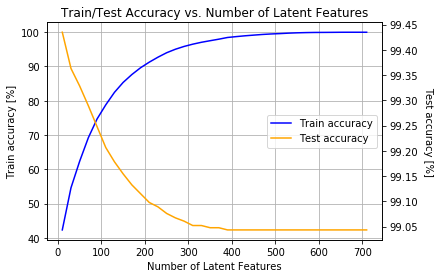

In [443]:
# visualize impact of number of latent features on accuracy of recommendations
fig, ax1 = plt.subplots()

# plot train accuracy vs. number of latent features 
ax1.plot(num_latent_features, 100*(1 - np.array(sum_errors_train)/df.shape[0]), color = 'blue', label="Train accuracy")
ax1.set_title('Train/Test Accuracy vs. Number of Latent Features')
ax1.grid(True)
ax1.set_xlabel('Number of Latent Features')
ax1.set_ylabel('Train accuracy [%]')

# create second y-axis and plot test accuracy vs. number of latent features 
ax2 = ax1.twinx()
ax2.plot(num_latent_features, 100*(1 - np.array(sum_errors_test)/df.shape[0]), color='orange', label="Test accuracy")
ax2.set_ylabel('Test accuracy [%]', rotation=270, labelpad=15)

# create legend
handle_1, label_1 = ax1.get_legend_handles_labels()
handle_2, label_2 = ax2.get_legend_handles_labels()
ax1.legend(handle_1 + handle_2, label_1 + label_2, loc='center right')

plt.show()

In [444]:
from sklearn.metrics import f1_score
# init f1 variables
f1_score_train = []
f1_score_test = []

# loop over number of latent features
for i in num_latent_features:
    # filter fitted SVD arrays by selecting the i latent features
    # ... of the training data
    s_train_latent, u_train_latent, vh_train_latent = np.diag(s_train[:i]), u_train[:, :i], vh_train[:i, :]
    
    # ... and testing data
    u_test_latent, vh_test_latent = u_test[:, :i], vh_test[:i, :]
    
    # perform the dot product on the created arrays
    user_item_train_latent = np.around(np.dot(np.dot(u_train_latent, s_train_latent), vh_train_latent))
    user_item_test_latent = np.around(np.dot(np.dot(u_test_latent, s_train_latent), vh_test_latent))
    
    # compute f1 score
    f1_score_train.append(f1_score(np.array(user_item_train).flatten(), user_item_train_latent.flatten(), labels=[1.0], average='macro'))
    f1_score_test.append(f1_score(np.array(user_item_test).flatten(), user_item_test_latent.flatten(), labels=[1.0], average='macro'))

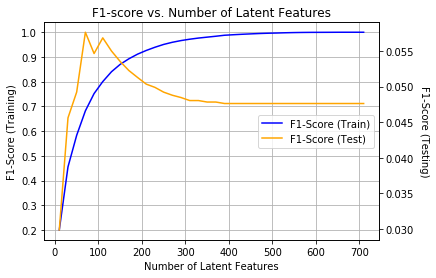

In [445]:
# visualize impact of number of latent features on F1-score
fig, ax1 = plt.subplots()

# plot training F1-score vs. number of latent features 
ax1.plot(num_latent_features, f1_score_train, color = 'blue', label="F1-Score (Train)")
ax1.set_title('F1-score vs. Number of Latent Features')
ax1.grid(True)
ax1.set_xlabel('Number of Latent Features')
ax1.set_ylabel('F1-Score (Training)')

# create second y-axis and plot testing F1-score vs. number of latent features 
ax2 = ax1.twinx()
ax2.plot(num_latent_features, f1_score_test, color='orange', label="F1-Score (Test)")
ax2.set_ylabel('F1-Score (Testing)', rotation=270, labelpad=15)

# create legend
handle_1, label_1 = ax1.get_legend_handles_labels()
handle_2, label_2 = ax2.get_legend_handles_labels()
ax1.legend(handle_1 + handle_2, label_1 + label_2, loc='center right')

plt.show()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Response:**

Surprisingly, the accuracy curve of the testing dataset dropped from 99.45% to around 99.05% when the number of latent features increased. This behaviour is reciprocal relative to the accuracy curve of the training data, which rises from 40% to nearly 100% when we increase the number of latent features as well.

The cause of this behaviour might be overfitting of the recommendations to the training data. I.e., that our model gets better and better in fitting the training dataset with an increasing number of latent features it but lacks in generalizing well to predictions on the testing set. As a result, we should use only a few latent features for the recommendation.

Additionally, the model matrix is mostly a sparse matrix, since we have only a small and/or unbalanced number of user-article-interactions. Thus, a large number of latent features is not required to make good recommendations.

In this case, a better metric might be the F1-score, we additionally applied in previous subsection. As seen in the visualization above, the F1-score for the testing dataset is maximum for around 80 to 100 latent features. After that, this F1- score decreases significantly due to overfitting, which can be observed on the rising F1-score for the training set.

We can state as a result, that recommendations made only by implementing a SVD performs not well when we have a very small sample of training and testing data. The intersection of articles interacted by users was very small, resulting in a lower certainty of the recommendations. Thus, we might have to add another recommendation technique to improve our results.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [446]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0